<a href="https://colab.research.google.com/github/yakovsushenok/Thesis/blob/main/MelSpectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from google.colab import drive
from sklearn.model_selection import StratifiedShuffleSplit
drive.mount('/content/gdrive')
import time
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
try:
    from scipy.fftpack import fft, ifft
except ImportError:
    from numpy.fft import fft, ifft
from scipy.signal import lfilter
import scipy.io as sio
from scipy import signal
import gc
import h5py
from torchsummary import summary
!pip install torchmetrics
from torchmetrics.functional import f1_score
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# extracting the training data (audio files) from the zip file (12 minutes)
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/train_short_audio.zip', 'r')
zip_ref.extractall('/content/tmp') 
zip_ref.close()

In [4]:
df_500 = pd.read_csv("/content/gdrive/MyDrive/train_metadata_more_than_500.csv")
df_500['primary_label'] = df_500['primary_label'].apply(lambda x: x - 1)
df_500 = df_500[['relative_path', 'primary_label']]

In [5]:
transform = transforms.MelSpectrogram(sample_rate=32000, n_mels = 128, f_min = 0, f_max = 16000,n_fft = 3200, win_length = 3200, hop_length = 800)
def get_mel_spec_from_file(file):
  mid = 2000000 # truncating or cutting the waveform tensors are less or more length
  waveform, sr = torchaudio.load(file)
  top_db = 80
  if len(waveform[0]) < mid:
    target = torch.zeros(mid) + 0.0005
    source = waveform[0]
    target[:len(source)] = source 
    spec = transform(target)
    return transforms.AmplitudeToDB(top_db=top_db)(spec)
  waveform = waveform[0]
  spec = transform(waveform[:mid])
  return transforms.AmplitudeToDB(top_db=top_db)(spec)

In [6]:
class MelSpecDS(Dataset):
  def __init__(self, df):
    self.df = df
  
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
   spec = get_mel_spec_from_file(self.df['relative_path'].iloc[idx])
   return (spec, torch.tensor(self.df['primary_label'].iloc[idx]))

def inference(model, val_dl):
  correct_prediction = 0
  total_prediction = 0
  outputsList = []
  labelsList = []
  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)


      inputs -= inputs.min(1, keepdim=True)[0]
      inputs /= inputs.max(1, keepdim=True)[0]
      
      inputs = inputs[None, :, :, :]
      inputs = inputs.permute(1,0,2,3)
      if torch.isnan(inputs).any() == True:
          inputs = torch.nan_to_num(inputs, nan = 0.5)
      # Get predictions
      outputs = model(inputs.float())

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
      outputsList.append(prediction.cpu().numpy())
      labelsList.append(labels.cpu().numpy())
  
  acc = correct_prediction/total_prediction
  print(f'Val Accuracy: {acc:.2f}')
  outputs = np.concatenate(outputsList)
  targets = np.concatenate(labelsList)
  f1 = f1_score(torch.from_numpy(outputs),torch.from_numpy(targets), num_classes = 12, average='micro')
  print(f"F1 score: {f1}")
  return f1, acc


In [8]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)
        self.shortcut = nn.Sequential()

        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=12):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,), resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input


device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu") #
myModel = ResNet(1, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=12) # resnet18
myModel = myModel.to(device)


def training(model, train_dl, num_epochs, val_dl):
  # Loss Function, Optimizer 
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= 10**(-5))
  
  val_accuracy_epoch_list = [] 
  train_accuracy_epoch_list = [] 
  best_f1 = 0
  epoch_f1 = 0

  # Epoch iterator
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    indices = []
    # Batch iterator
    j = 0
    for i, data in enumerate(train_dl):

        inputs, labels = torch.tensor(data[0]).to(device), torch.tensor(data[1]).to(device) # Get the input features and target labels, and put them on the GPU
        if torch.isnan(torch.tensor(data[0])).any() == True:
          j += 1
          continue
        
        d = inputs
        inputs -= inputs.min(0, keepdim=True)[0]
        inputs /= inputs.max(0, keepdim=True)[0]
        inputs = inputs[None, :, :, :]
        inputs = inputs.permute(1,0,2,3)
        if torch.isnan(inputs).any() == True:
          inputs = torch.nan_to_num(inputs, nan = 0.5)
        if torch.isnan(inputs).any() == True:
          print("Some inputs are NAN")
       
        optimizer.zero_grad() # Zero the parameter gradients

        # forward + backward + optimize
        outputs = model(inputs.float())
       
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # Keep stats for Loss and Accuracy

        _, prediction = torch.max(outputs,1) # Get the predicted class with the highest score
        correct_prediction += (prediction == labels).sum().item() # Count of predictions that matched the target label
        total_prediction += prediction.shape[0]

        

    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    print(f"TESTING:")
    train_accuracy_epoch_list.append(acc)
    epoch_f1, val_acc = inference(model, val_dl)
    val_accuracy_epoch_list.append(val_acc)
    if epoch_f1 > best_f1:
      torch.save(model.state_dict(), "/content/gdrive/MyDrive/BestResnet18MelSpec.pt")
      best_f1 = epoch_f1
      print("saved")
    print("\n")

  print('Finished Training')
  return train_accuracy_epoch_list, val_accuracy_epoch_list



NUM_EPOCHS = 30
# Initializing the dataset
myds = MelSpecDS(df_500)
# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items*(0.80))
num_val = int((num_items - num_train)//2)
num_test = num_items - num_train - num_val
print(num_train,num_val, num_test)
train_ds, val_ds, test_ds = random_split(myds, [num_train, num_val, num_test])
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=10, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10, shuffle=False)

train_acc_list, val_acc_list = training(myModel, train_dl, NUM_EPOCHS, val_dl) # Training

4800 600 600


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 1, Loss: 2.34, Accuracy: 0.20
TESTING:
Val Accuracy: 0.19
F1 score: 0.18833331763744354
saved


Epoch: 2, Loss: 1.98, Accuracy: 0.35
TESTING:
Val Accuracy: 0.28
F1 score: 0.2750000059604645
saved


Epoch: 3, Loss: 1.75, Accuracy: 0.45
TESTING:
Val Accuracy: 0.37
F1 score: 0.3700000047683716
saved


Epoch: 4, Loss: 1.57, Accuracy: 0.51
TESTING:
Val Accuracy: 0.38
F1 score: 0.38333332538604736
saved


Epoch: 5, Loss: 1.47, Accuracy: 0.55
TESTING:
Val Accuracy: 0.41
F1 score: 0.41333332657814026
saved


Epoch: 6, Loss: 1.36, Accuracy: 0.58
TESTING:
Val Accuracy: 0.46
F1 score: 0.46166667342185974
saved


Epoch: 7, Loss: 1.29, Accuracy: 0.61
TESTING:
Val Accuracy: 0.47
F1 score: 0.47333332896232605
saved


Epoch: 8, Loss: 1.19, Accuracy: 0.65
TESTING:
Val Accuracy: 0.47
F1 score: 0.46666666865348816


Epoch: 9, Loss: 1.15, Accuracy: 0.65
TESTING:
Val Accuracy: 0.49
F1 score: 0.4933333396911621
saved


Epoch: 10, Loss: 1.08, Accuracy: 0.68
TESTING:
Val Accuracy: 0.54
F1 score: 0.5383

In [9]:
print(train_acc_list) 
print(val_acc_list) 

[0.20125, 0.34770833333333334, 0.45125, 0.5072916666666667, 0.5464583333333334, 0.58375, 0.6097916666666666, 0.6539583333333333, 0.653125, 0.680625, 0.7033333333333334, 0.7122916666666667, 0.7204166666666667, 0.7333333333333333, 0.7504166666666666, 0.7529166666666667, 0.7645833333333333, 0.7789583333333333, 0.7864583333333334, 0.7954166666666667, 0.7970833333333334, 0.7977083333333334, 0.809375, 0.8147916666666667, 0.8139583333333333, 0.8322916666666667, 0.8327083333333334, 0.841875, 0.8360416666666667, 0.84625]
[0.18833333333333332, 0.275, 0.37, 0.38333333333333336, 0.41333333333333333, 0.46166666666666667, 0.47333333333333333, 0.4666666666666667, 0.49333333333333335, 0.5383333333333333, 0.535, 0.5483333333333333, 0.5466666666666666, 0.56, 0.565, 0.535, 0.5616666666666666, 0.5583333333333333, 0.59, 0.605, 0.5766666666666667, 0.5733333333333334, 0.6, 0.5983333333333334, 0.6166666666666667, 0.605, 0.62, 0.6266666666666667, 0.6333333333333333, 0.6283333333333333]


In [10]:
model = ResNet(1, ResBlock, [2, 2, 2, 2], useBottleneck=False, outputs=12) # resnet18
device = torch.device("cuda:0" if torch.cuda.is_available() else  "cpu") #
model.load_state_dict(torch.load("/content/gdrive/MyDrive/BestResnet18MelSpec.pt"))
model = model.to(device)
inference(model, test_dl)

Val Accuracy: 0.64
F1 score: 0.6366666555404663


(tensor(0.6367), 0.6366666666666667)

In [ ]:
import librosa
import librosa.display as lbd


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

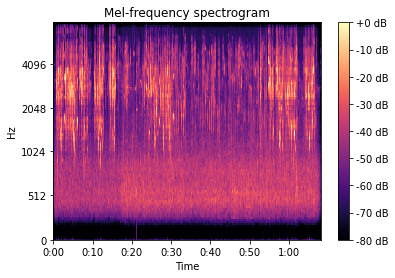

In [ ]:
spec, sr = librosa.load(df_500['relative_path'].iloc[3])
S = librosa.feature.melspectrogram(y=spec, n_mels = 128, sr=sr, n_fft = 3200, win_length = 3200, hop_length = 800)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
spec, sr = librosa.load(df_500['relative_path'].iloc[100])
sr

22050

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
font = {'family' : 'normal',
        'size'   : 40}

plt.rc('font', **font)

In [ ]:
waveform, sr = torchaudio.load(df_500['relative_path'].iloc[3])
plot_waveform(waveform, sr)

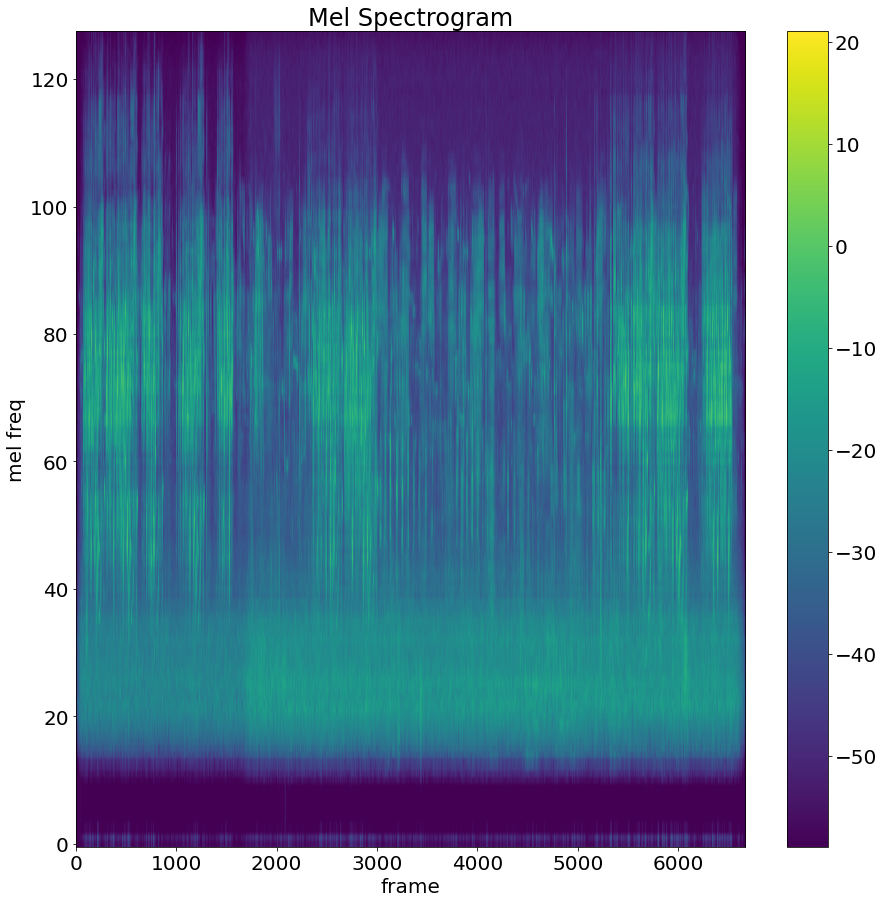

In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
  return librosa.power_to_db(spec)

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
spec_plotted = plot_spectrogram(
    melspec[0], title="Mel Spectrogram", ylabel='mel freq')

In [ ]:
melspectrogram = melspec[0]
np.amin(spec_plotted[0])

-58.9469

In [ ]:
epsc = 0.000001

def mrcg_extract(sig, sampFreq = 32000): # Sample frequency is always 32,000 in our case
    # Code From: https://github.com/MoongMoong/MRCG_python/blob/master/MRCG_python_master/mrcg/MRCG.py
    
    beta = 1000 / np.sqrt(sum(map(lambda x:x*x,sig)) / len(sig))
    sig = sig*beta
    sig = sig.reshape(len(sig), 1)
    g = gammatone(sig, 64, sampFreq)
    cochlea1 = np.log10(cochleagram(g, int(sampFreq * 0.025), int(sampFreq * 0.010)) + 0.0000005)
    cochlea2 = np.log10(cochleagram(g, int(sampFreq * 0.200), int(sampFreq * 0.010)) + 0.0000005) # 768, x 
    cochlea1 = cochlea1[:,:]
    cochlea2 = cochlea2[:,:]
    cochlea3 = get_avg(cochlea1, 5, 5)
    cochlea4 = get_avg(cochlea1, 11, 11)
    
    all_cochleas = np.concatenate([cochlea1,cochlea2,cochlea3,cochlea4],0)
    del0 = deltas(all_cochleas)
    ddel = deltas(deltas(all_cochleas, 5), 5)

    ouotput = np.concatenate((all_cochleas, del0, ddel), 0)

    return ouotput

def gammatone(insig, numChan=128, fs = 16000): # 
    fRange = [1000, 20000] # try from 1000 to 20000 (was [50, 8000])
    filterOrder = 4
    gL = 2048
    sigLength = len(insig)
    phase = np.zeros([numChan, 1])
    erb_b = hz2erb(fRange)

    
    erb_b_diff = (erb_b[1]-erb_b[0])/(numChan-1)
    erb = np.arange(erb_b[0], erb_b[1]+epsc, erb_b_diff)
    cf = erb2hz(erb)
    b = [1.019 * 24.7 * (4.37 * x / 1000 + 1) for x in cf]
    gt = np.zeros([numChan, gL])
    tmp_t = np.arange(1,gL+1)/fs
    for i in range(numChan):
        gain = 10**((loudness(cf[i])-60)/20)/3*(2 * np.pi * b[i] / fs)**4
        tmp_temp = [gain*(fs**3)*x**(filterOrder - 1)*np.exp(-2 * np.pi * b[i] * x)*np.cos(2 * np.pi * cf[i] * x + phase[i]) for x in tmp_t]
        tmp_temp2 = np.reshape(tmp_temp, [1, gL])

        gt[i, :] = tmp_temp2

    sig = np.reshape(insig,[sigLength,1])
    gt2 = np.transpose(gt)
    resig = np.matlib.repmat(sig,1,numChan)
    r = np.transpose(fftfilt(gt2,resig,numChan))
    return r

def hz2erb(hz):  
    erb1 = 0.00437
    erb2 = np.multiply(erb1,hz)
    erb3 = np.subtract(erb2,-1)
    erb4 = np.log10(erb3)
    erb = 21.4 *erb4
    return erb

def erb2hz(erb): 
    hz = [(10**(x/21.4)-1)/(0.00437) for x in erb]
    return hz

def loudness(freq): 
    dB=60
    fmat = sio.loadmat('/content/gdrive/MyDrive/f_af_bf_cf.mat')
    af = fmat['af'][0]
    bf = fmat['bf'][0]
    cf = fmat['cf'][0]
    ff = fmat['ff'][0]
    i = 0
    while ff[i] < freq and i < len(ff) - 1: # my code:  i < len(ff)
        i = i + 1

    afy = af[i - 1] + (freq - ff[i - 1]) * (af[i] - af[i - 1]) / (ff[i] - ff[i - 1])
    bfy = bf[i - 1] + (freq - ff[i - 1]) * (bf[i] - bf[i - 1]) / (ff[i] - ff[i - 1])
    cfy = cf[i - 1] + (freq - ff[i - 1]) * (cf[i] - cf[i - 1]) / (ff[i] - ff[i - 1])
    loud = 4.2 + afy * (dB - cfy) / (1 + bfy * (dB - cfy))
    return loud

def fftfilt(b,x,nfft): 
    fftflops = [18, 59, 138, 303, 660, 1441, 3150, 6875, 14952, 32373, 69762,
                149647, 319644, 680105, 1441974, 3047619, 6422736, 13500637, 28311786,
                59244791, 59244791*2.09]
    nb, _ = np.shape(b)
    nx, mx = np.shape(x)
    n_min = 0
    while 2**n_min < nb-1:
        n_min = n_min+1
    n_temp = np.arange(n_min, 21 + epsc, 1)
    n = np.power(2,n_temp)
    fftflops = fftflops[n_min-1:21]
    L = np.subtract(n,nb-1)
    lenL= np.size(L)
    temp_ind0 = np.ceil(np.divide(nx,L))
    temp_ind = np.multiply(temp_ind0,fftflops)
    temp_ind = np.array(temp_ind)
    ind = np.argmin(temp_ind)
    nfft=int(n[ind])
    L=int(L[ind])
    b_tr = np.transpose(b)
    B_tr = fft(b_tr,nfft)
    B = np.transpose(B_tr)
    y = np.zeros([nx, mx])
    istart = 0
    while istart < nx :
        iend = min(istart+L,nx)
        if (iend - istart) == 1 :
            X = x[0][0]*np.ones([nx,mx])
        else :
            xtr = np.transpose(x[istart:iend][:])
            Xtr = fft(xtr,nfft)
            X = np.transpose(Xtr)
        temp_Y = np.transpose(np.multiply(B,X))
        Ytr = ifft(temp_Y,nfft)
        Y = np.transpose(Ytr)
        yend = np.min([nx, istart + nfft])
        y[istart:yend][:] = y[istart:yend][:] + np.real(Y[0:yend-istart][:])

        istart = istart + L
    
    return y

def cochleagram(r, winLength = 320, winShift=160): 
    numChan, sigLength = np.shape(r)
    increment = winLength / winShift
    M = np.floor(sigLength / winShift)
    a = np.zeros([numChan, int(M)])
    rs = np.square(r)
    rsl = np.concatenate((np.zeros([numChan,winLength-winShift]),rs),1)
    for m in range(int(M)):
        temp = rsl[:,m*winShift : m*winShift+winLength]
        a[:, m] = np.sum(temp,1)

    return a

def get_avg( m , v_span, h_span): 
    nr,nc = np.shape(m)

    fil_size = (2 * v_span + 1) * (2 * h_span + 1)
    meanfil = np.ones([1+2*h_span,1+2*h_span])
    meanfil = np.divide(meanfil,fil_size)

    out = signal.convolve2d(m, meanfil, boundary='fill', fillvalue=0, mode='same')
    return out

def deltas(x, w=9) : 
    nr,nc = np.shape(x)
    if nc ==0 :
        d= x
    else :
        hlen = int(np.floor(w / 2))
        w = 2 * hlen + 1
        win=np.arange(hlen, int(-(hlen+1)), -1)
        temp = x[:, 0]
        fx = np.matlib.repmat(temp.reshape([-1,1]), 1, int(hlen))
        temp = x[:, nc-1]
        ex = np.matlib.repmat(temp.reshape([-1,1]), 1, int(hlen))
        xx = np.concatenate((fx, x, ex),1)
        d = lfilter(win, 1, xx, 1)
        d = d[:,2*hlen:nc+2*hlen]

    return d

def get_mrcg_from_file(file):
  mid = 2000000 # zero padding so that mrcgs are 20 seconds max # 2000000 for 60 sec
  waveform, sr = torchaudio.load(file)
  if len(waveform[0]) < mid:
    target = torch.zeros(mid)
    source = waveform[0]
    target[:len(source)] = source
    return mrcg_extract(target)
  else:
    waveform = waveform[0]
    return mrcg_extract(waveform[:mid])


mrcg = get_mrcg_from_file(df_500['relative_path'].iloc[3])

In [ ]:
transformed = torch.from_numpy(mrcg)
transformed = transformed[None, :, :]
transformed = torch.cat([transformed[ :, :round(transformed.shape[1]/3), :], transformed[ :, round(transformed.shape[1]/3):round(transformed.shape[1]*2/3), :],transformed[ :, round(transformed.shape[1]*2/3):, : ]], dim = 0)

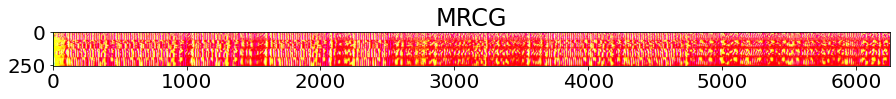

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]
font = {'family' : 'normal',
        'size'   : 20}

plt.rc('font', **font)



plt.imshow(transformed.permute(1, 2, 0))
plt.title("MRCG")
plt.show()

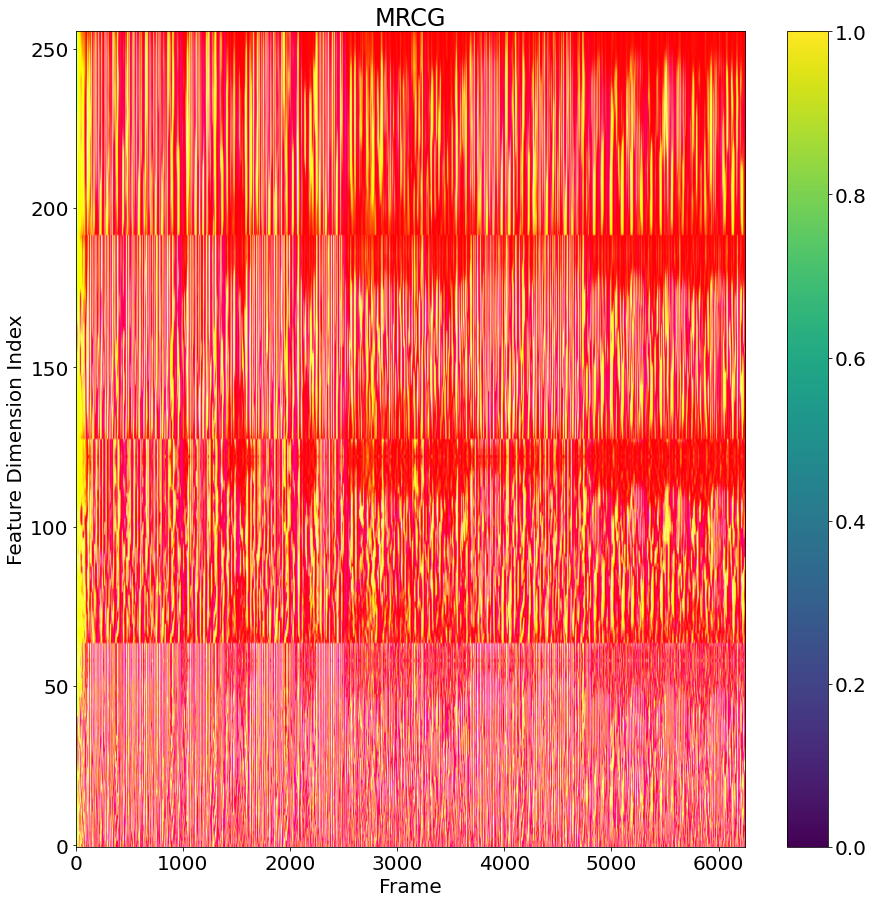

In [ ]:
fig, axs = plt.subplots(1,1)
trans = transformed.permute(1, 2, 0)
trans = trans.detach().cpu().numpy()


im = axs.imshow(trans, origin = "lower", aspect = "auto")
plt.title("MRCG")
plt.xlabel("Frame")
plt.ylabel("Feature Dimension Index")
fig.colorbar(im,ax=axs)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,1)
trans = transformed.permute(1, 2, 0)

trans -= trans.min(0, keepdim=True)[0]
trans /= trans.max(0, keepdim=True)[0]

trans = trans.detach().cpu().numpy()

trans =  np.mean(trans, axis = 2)

im = axs.imshow(trans, origin = "lower", aspect = "auto")
plt.title("MRCG")
plt.xlabel("Frame")
plt.ylabel("Feature Dimension Index")
fig.colorbar(im,ax=axs)
plt.show()

NameError: ignored

In [ ]:
tr = np.mean(trans, axis = 2)
tr.shape

(256, 6250)